In [8]:
from derivkit import DerivativeKit
import matplotlib.pyplot as plt
import os
import numpy as np
from derivkit import DerivativePlotter

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def show_adaptive_fit_noisy(plotter, noise_std=0.02, seed=7,
                            fit_tolerance=0.05, min_samples=7, include_zero=True):
    """
    In-notebook demo of the adaptive fit with *per-evaluation* noise.
    - Fresh noise is added on every function evaluation.
    - Plots which points were used vs excluded and overlays the fitted polynomial.
    - Returns the diagnostics dict from the adaptive run.
    """
    rng = np.random.default_rng(seed)

    # Per-evaluation noisy wrapper around the plotter's base function
    def noisy_f(x):
        y = plotter.function(x)
        return y + rng.normal(0.0, noise_std, size=np.shape(y))

    # Temporarily swap the function used by the adaptive method
    orig_f = plotter.derivs.adaptive.function
    plotter.derivs.adaptive.function = noisy_f
    try:
        _, diag = plotter.derivs.adaptive.compute(
            diagnostics=True,
            fit_tolerance=fit_tolerance,
            min_samples=min_samples,
            include_zero=include_zero,
        )
    finally:
        # Always restore the original (clean) function
        plotter.derivs.adaptive.function = orig_f

    # --- Extract diagnostics ---
    x_all = diag["x_all"]
    y_all = diag["y_all"]
    if y_all.ndim == 2:
        y_all = y_all[:, 0]  # assume first component for plotting

    used_mask = diag["used_mask"][0] if diag["used_mask"] else np.zeros_like(x_all, dtype=bool)
    x_used, y_used   = x_all[used_mask],   y_all[used_mask]
    x_excl, y_excl   = x_all[~used_mask],  y_all[~used_mask]

    # --- Build a display polynomial with the same normalization the adaptive code uses ---
    deg = plotter.derivative_order
    x0  = plotter.x_center
    if len(x_used) >= max(5, deg + 2):
        t_used = x_used - x0
        h = max(np.max(np.abs(t_used)), 1e-12)
        u_used = t_used / h
        coeffs = np.polyfit(u_used, y_used, deg=deg)  # unweighted for display
        poly_u = np.poly1d(coeffs)

        x_fit = np.linspace(np.min(x_all), np.max(x_all), 400)
        y_fit = poly_u((x_fit - x0) / h)
    else:
        x_fit = y_fit = None

    # --- Plot ---
    plt.figure(figsize=(7, 5))
    plt.scatter(x_excl, y_excl, s=28, color='0.5', label='Excluded', zorder=2)
    if len(x_used):
        plt.scatter(x_used, y_used, s=36, facecolor='white', edgecolor='black',
                    label='Used', zorder=3)
    if x_fit is not None:
        plt.plot(x_fit, y_fit, color='black', lw=2, label=f'Poly fit (deg={deg})', zorder=4)

    plt.axvline(plotter.x_center, color='0.7', linestyle='--', lw=1.2, label='$x_0$')
    plt.xlabel('x'); plt.ylabel(r'$f(x) + \epsilon$')
    plt.title('Adaptive polynomial fit with per-evaluation noise')
    plt.legend(frameon=False, loc='best')
    plt.show()

    return diag


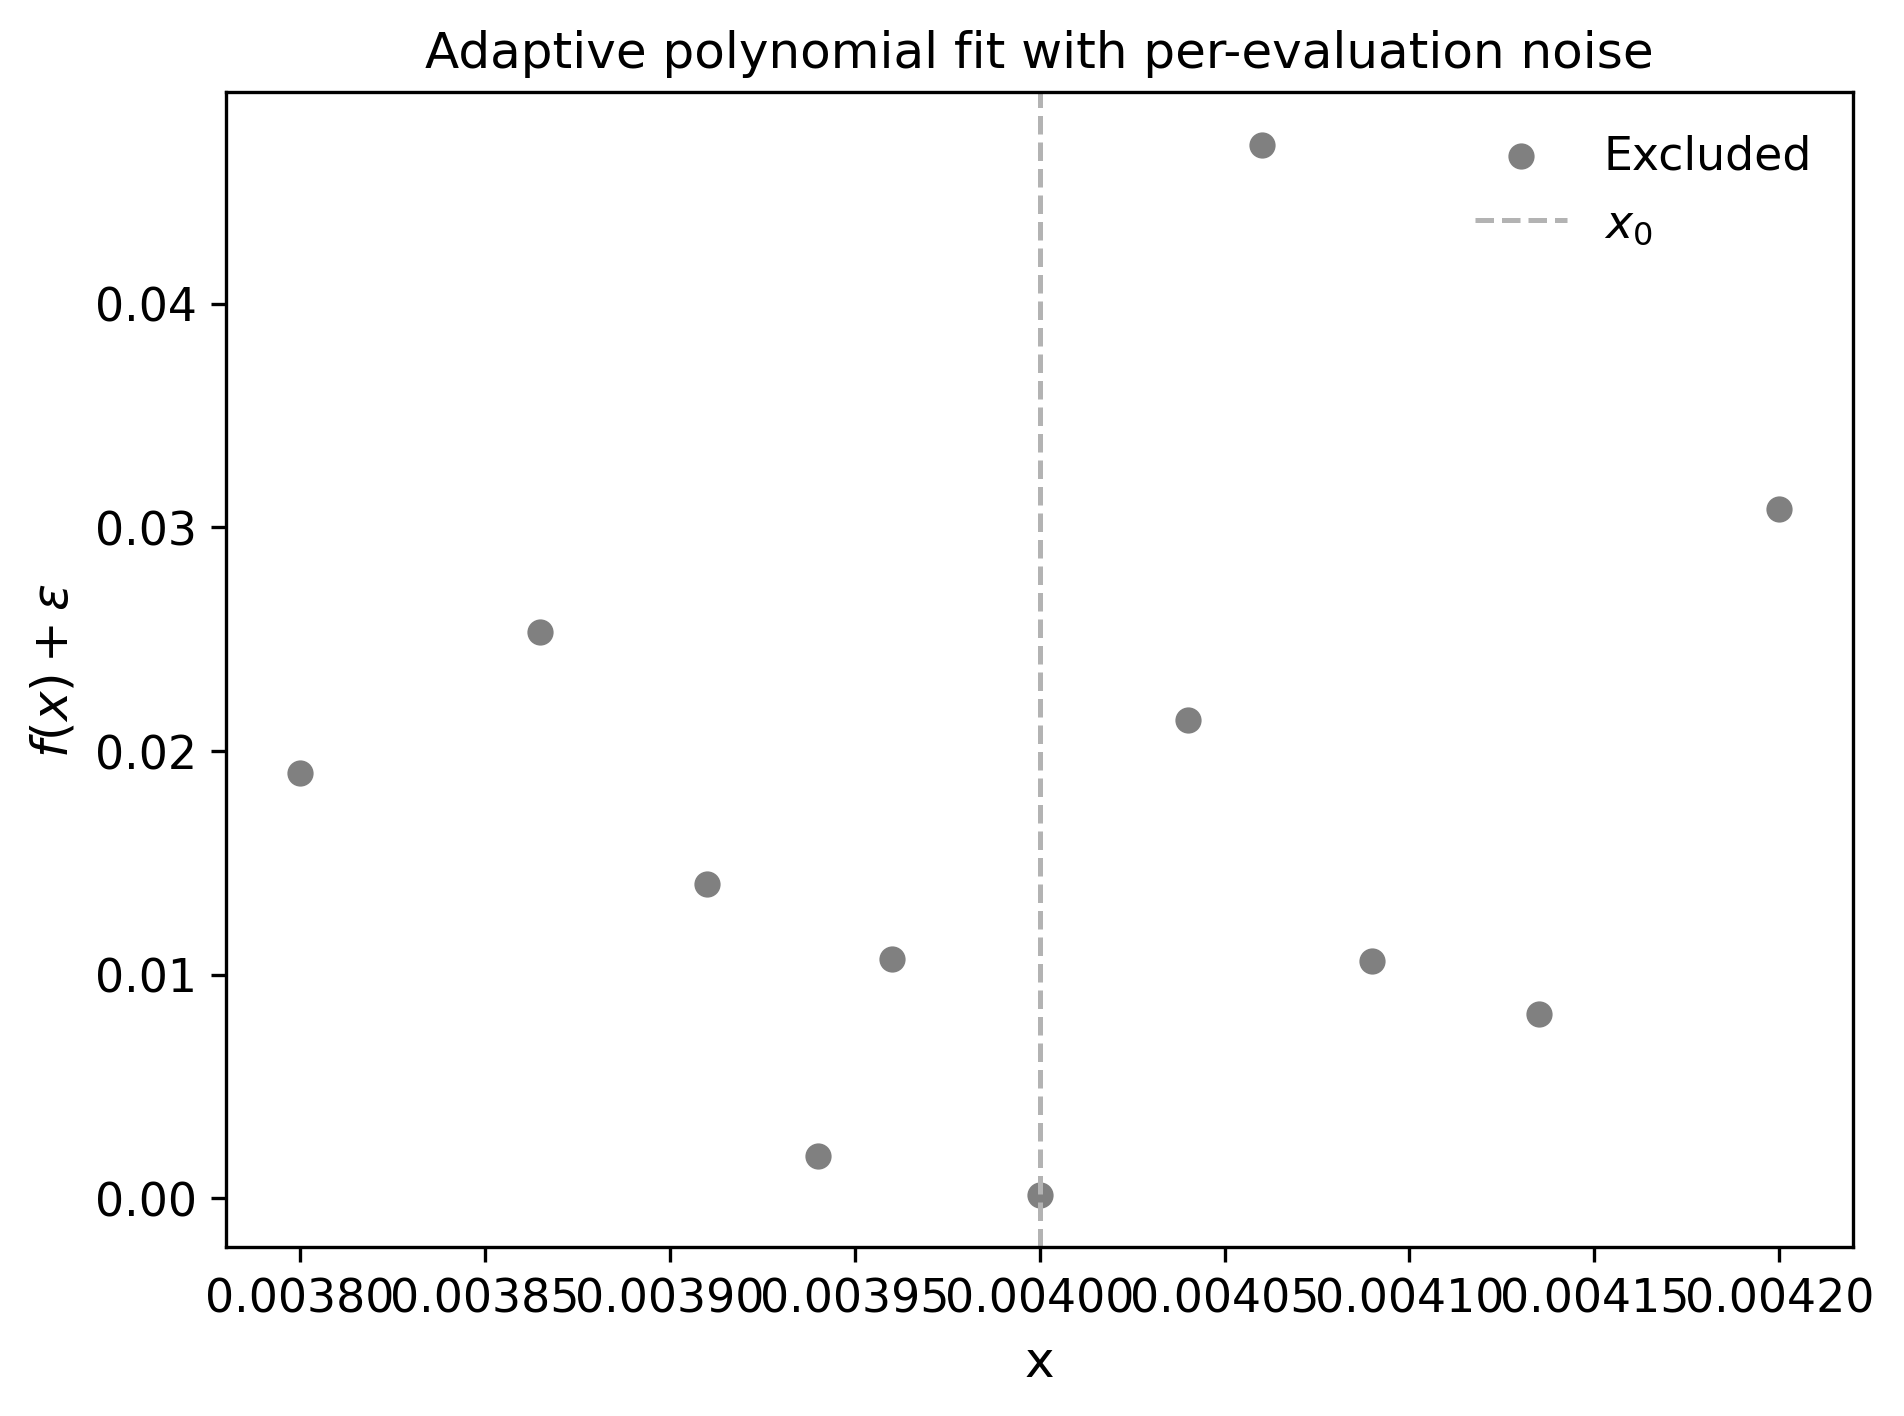

In [18]:
# Example function and plotter
f = lambda x: np.exp(-x**2) * np.sin(5*x)
plotter = DerivativePlotter(function=f, x_center=0.004, derivative_order=1, plot_dir="plots")

# Show one noisy adaptive fit
diag = show_adaptive_fit_noisy(plotter, noise_std=0.02, seed=7, fit_tolerance=0.05, min_samples=7)
